In [5]:
import sys, os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import linregress
from matplotlib.backends.backend_pdf import PdfPages
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
from sklearn.cluster import KMeans
%matplotlib inline
import cv2
import xarray as xr
mpl.rcParams.update({'font.size':10})

import fmEphys

In [2]:
hffm = fmEphys.read_group_h5('/home/niell_lab/hffm/freely_moving_ephys/batch_files/hffm_012523_keyed_v2.h5')

In [6]:
hffm['norm_waveform'] = hffm['waveform']
for ind, row in hffm.iterrows():
    if type(row['waveform']) == list:
        starting_val = np.mean(row['waveform'][:6])
        center_waveform = [i-starting_val for i in row['waveform']]
        norm_waveform = center_waveform / -np.min(center_waveform)
        hffm.at[ind, 'waveform_trough_width'] = len(norm_waveform[norm_waveform < -0.2])
        hffm.at[ind, 'AHP'] = norm_waveform[27]
        hffm.at[ind, 'waveform_peak'] = norm_waveform[18]
        hffm.at[ind, 'norm_waveform'] = norm_waveform

km_labels = KMeans(n_clusters=2).fit(list(hffm['norm_waveform'][hffm['waveform_peak'] < 0].to_numpy())).labels_
# make inhibitory is always group 0
# excitatory should always have a smaller mean waveform trough
# if it's larger, flip the kmeans labels
if np.mean(hffm['waveform_trough_width'][hffm['waveform_peak']<0][km_labels==0]) > np.mean(hffm['waveform_trough_width'][hffm['waveform_peak']<0][km_labels==1]):
    km_labels = [0 if i==1 else 1 for i in km_labels]

hffm['waveform_km_label'] = np.nan
count = 0
for ind, row in hffm.iterrows():
    if row['waveform_peak'] < 0 and row['AHP'] < 0.7:
        hffm.at[ind, 'waveform_km_label'] = km_labels[count]
        count = count+1

hffm['exc_or_inh'] = np.nan
# make new column of strings for excitatory vs inhibitory clusters
for ind, row in hffm.iterrows():
    if row['waveform_km_label'] == 0:
        hffm.at[ind, 'exc_or_inh'] = 'inh'
    elif row['waveform_km_label'] == 1:
        hffm.at[ind, 'exc_or_inh'] = 'exc'

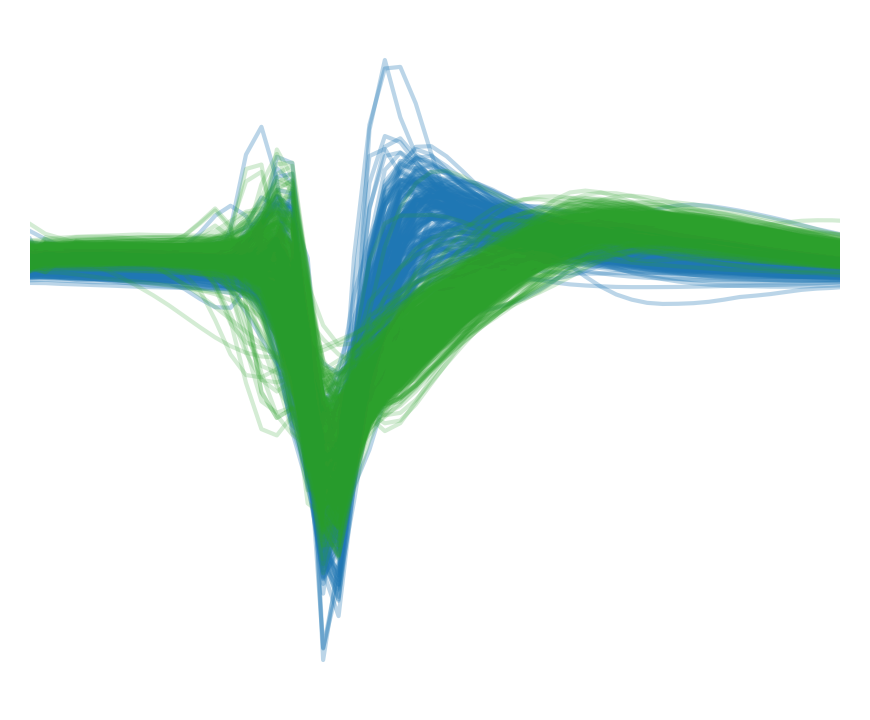

In [37]:
fig, ax = plt.subplots(1,1,figsize=(3,2.5), dpi=300)

# for wv in hffm['waveform'][hffm['exc_or_inh']=='inh']:
#     plt.plot(np.arange(len(wv))*1000/30000, wv, color='tab:green', alpha=0.5, linewidth=1)
for wv in hffm['waveform'][hffm['exc_or_inh']=='inh']:
    ax.plot(np.arange(len(wv))*1000/30000, wv, color='tab:blue', alpha=0.3, linewidth=1)

for wv in hffm['waveform'][hffm['exc_or_inh']=='exc']:
    ax.plot(np.arange(len(wv))*1000/30000, wv, color='tab:green', alpha=0.2, linewidth=1)

ax.set_xlim([0,1.75])
ax.axis('off')
fig.tight_layout()
fig.savefig('/home/niell_lab/Desktop/excinh.pdf')